# Collaborative Filtering for Movie Recommendations

**Author:** [Siddhartha Banerjee](https://twitter.com/sidd2006)<br>
**Date created:** 2020/05/24<br>
**Last modified:** 2020/05/24<br>
**Description:** Recommending movies using a model trained on Movielens dataset.

## Introduction

This example demonstrates
[Collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering)
using the [Movielens dataset](https://www.kaggle.com/c/movielens-100k)
to recommend movies to users.
The MovieLens ratings dataset lists the ratings given by a set of users to a set of movies.
Our goal is to be able to predict ratings for movies a user has not yet watched.
The movies with the highest predicted ratings can then be recommended to the user.

The steps in the model are as follows:

1. Map user ID to a "user vector" via an embedding matrix
2. Map movie ID to a "movie vector" via an embedding matrix
3. Compute the dot product between the user vector and movie vector, to obtain
the a match score between the user and the movie (predicted rating).
4. Train the embeddings via gradient descent using all known user-movie pairs.

**References:**

- [Collaborative Filtering](https://dl.acm.org/doi/pdf/10.1145/371920.372071)
- [Neural Collaborative Filtering](https://dl.acm.org/doi/pdf/10.1145/3038912.3052569)


In [52]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
import random

from jupyterthemes import jtplot
jtplot.style()

## First, load the data and apply preprocessing


In [2]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)


## First, need to perform some preprocessing to encode users and movies as integer indices.

In [3]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)


Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


## Adding noise to the ratings

In [12]:
noise_scales = [0.5, 1.0, 1.5, 2.0]

def addNoises(noise_scales):
    
    def correction(x):
        if x < 0.0:
            return 0
        elif x > 5.0:
            return 5.0
        else:
            return x
        
    for scale in noise_scales:
        df["noisy_rating_" + str(scale)] = df["rating"].apply(lambda x: x + (random.choice([-1,1]) * np.random.laplace(scale=scale)))
    

        df["noisy_rating_" + str(scale)] = df["noisy_rating_" + str(scale)].apply(correction)
        print("Mean Noise added (for scale " + str(scale) + "):",(df["rating"]-df["noisy_rating_" + str(scale)]).mean())
        
addNoises(noise_scales)
df

Mean Noise added (for scale 0.5): 0.04969565607758929
Mean Noise added (for scale 1.0): 0.1430473822704418
Mean Noise added (for scale 1.5): 0.2389160581617666
Mean Noise added (for scale 2.0): 0.3320382928903571


,userId,movieId,rating,timestamp,user,movie,noisy_rating_0.5,noisy_rating_1.0,noisy_rating_1.5,noisy_rating_2.0
0,1,1,4.0,964982703,0,0,4.064597,3.556441,3.391025,3.417030
1,1,3,4.0,964981247,0,1,3.199573,4.224058,3.799903,4.121923
2,1,6,4.0,964982224,0,2,4.161277,5.000000,1.614217,5.000000
3,1,47,5.0,964983815,0,3,4.533462,4.150380,4.288968,5.000000
4,1,50,5.0,964982931,0,4,5.000000,3.713520,1.194455,3.541102
...,...,...,...,...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,609,3120,4.581796,1.743055,5.000000,5.000000
100832,610,168248,5.0,1493850091,609,2035,4.568303,4.699660,5.000000,5.000000
100833,610,168250,5.0,1494273047,609,3121,4.309161,3.859366,4.753573,4.681704
100834,610,168252,5.0,1493846352,609,1392,5.000000,5.000000,4.895644,5.000000


## Prepare training and validation data


In [13]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

y_noisy = dict()
def getNoisyYs(noise_scales):
    for scale in noise_scales:
        y_noisy_temp = df["noisy_rating_" + str(scale)].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
        y_noisy["train_" + str(scale)] = y_noisy_temp[:train_indices]
        y_noisy["val_" + str(scale)] = y_noisy_temp[train_indices:]

getNoisyYs(noise_scales)
y_noisy

{'train_0.5': array([1.        , 0.41074042, 0.53247649, ..., 0.34850064, 0.93437603,
        0.12080325]),
 'val_0.5': array([0.42321142, 0.81361713, 0.49557022, ..., 0.40966747, 0.5693652 ,
        0.94927373]),
 'train_1.0': array([0.71042499, 0.62908492, 0.99530634, ..., 0.6354018 , 1.        ,
        0.28918996]),
 'val_1.0': array([0.85248393, 1.        , 0.5336478 , ..., 0.66242767, 0.41588621,
        0.95913232]),
 'train_1.5': array([ 0.75651156,  0.87494635,  0.18089342, ...,  0.67277668,
         0.9136248 , -0.0913419 ]),
 'val_1.5': array([0.55440921, 0.24760385, 1.        , ..., 0.69089101, 0.3883182 ,
        0.65029824]),
 'train_2.0': array([ 0.0759408 ,  0.62798085,  1.        , ...,  0.55506714,
         0.96522442, -0.11111111]),
 'val_2.0': array([ 0.11051435,  1.        , -0.11111111, ...,  0.08574313,
         0.68926577,  1.        ])}

## Create the model

We embed both users and movies in to 50-dimensional vectors.

The model computes a match score between user and movie embeddings via a dot product,
and adds a per-movie and per-user bias. The match score is scaled to the `[0, 1]`
interval via a sigmoid (since our ratings are normalized to this range).


In [14]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model_wo_noise = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model_wo_noise.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)


## Train the model based on the data split


In [7]:
history_wo_noise = model_wo_noise.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)


Epoch 1/5
1418/1418 [==============================] - 9s 6ms/step - loss: 0.6582 - val_loss: 0.6206
Epoch 2/5
1418/1418 [==============================] - 9s 6ms/step - loss: 0.6162 - val_loss: 0.6195
Epoch 3/5
1418/1418 [==============================] - 9s 6ms/step - loss: 0.6092 - val_loss: 0.6142
Epoch 4/5
1418/1418 [==============================] - 8s 6ms/step - loss: 0.6075 - val_loss: 0.6158
Epoch 5/5
1418/1418 [==============================] - 8s 6ms/step - loss: 0.6097 - val_loss: 0.6166


## Plot training and validation loss


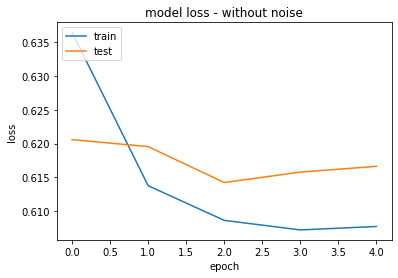

In [8]:
plt.plot(history_wo_noise.history["loss"])
plt.plot(history_wo_noise.history["val_loss"])
plt.title("model loss - without noise")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


In [9]:
model1 = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model1.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)
history1 = model1.fit(
    x=x_train,
    y=y_noisy_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_noisy_val),
)


Epoch 1/5
1418/1418 [==============================] - 9s 6ms/step - loss: 0.6579 - val_loss: 0.6200
Epoch 2/5
1418/1418 [==============================] - 8s 6ms/step - loss: 0.6154 - val_loss: 0.6177
Epoch 3/5
1418/1418 [==============================] - 8s 6ms/step - loss: 0.6105 - val_loss: 0.6148
Epoch 4/5
1418/1418 [==============================] - 8s 6ms/step - loss: 0.6081 - val_loss: 0.6121
Epoch 5/5
1418/1418 [==============================] - 9s 6ms/step - loss: 0.6074 - val_loss: 0.6134


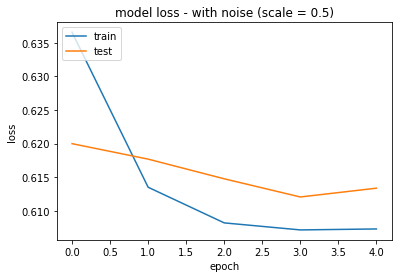

In [10]:
plt.plot(history1.history["loss"])
plt.plot(history1.history["val_loss"])
plt.title("model loss - with noise (scale = 0.5)")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


## Show top 10 movie recommendations to a user


In [11]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model1.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)


Showing recommendations for user: 372
Movies with high ratings from user
--------------------------------
Heat (1995) : Action|Crime|Thriller
Fugitive, The (1993) : Thriller
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) : Action|Adventure
Star Wars: Episode VI - Return of the Jedi (1983) : Action|Adventure|Sci-Fi
Godfather: Part II, The (1974) : Crime|Drama
--------------------------------
Top 10 movie recommendations
--------------------------------
Philadelphia Story, The (1940) : Comedy|Drama|Romance
North by Northwest (1959) : Action|Adventure|Mystery|Romance|Thriller
Some Like It Hot (1959) : Comedy|Crime
Casablanca (1942) : Drama|Romance
Maltese Falcon, The (1941) : Film-Noir|Mystery
Chinatown (1974) : Crime|Film-Noir|Mystery|Thriller
Cool Hand Luke (1967) : Drama
American History X (1998) : Crime|Drama
Fight Club (1999) : Action|Crime|Drama|Thriller
Cinderella Man (2005) : Drama|Romance


In [20]:
def trainModels(noise_scales):
    model = dict()
    history = dict()
    for scale in noise_scales:
        model[str(scale)] = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
        model[str(scale)].compile(
            loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
        )
        history[str(scale)] = model[str(scale)].fit(
            x=x_train,
            y=y_noisy["train_" + str(scale)],
            batch_size=64,
            epochs=5,
            verbose=1,
            validation_data=(x_val, y_noisy["val_" + str(scale)]),
        )
    return model,history
        
model,history = trainModels(noise_scales)

Epoch 1/5
1418/1418 [==============================] - 10s 7ms/step - loss: 0.6627 - val_loss: 0.6309
Epoch 2/5
1418/1418 [==============================] - 10s 7ms/step - loss: 0.6260 - val_loss: 0.6300
Epoch 3/5
1418/1418 [==============================] - 8s 6ms/step - loss: 0.6216 - val_loss: 0.6263
Epoch 4/5
1418/1418 [==============================] - 8s 6ms/step - loss: 0.6208 - val_loss: 0.6247
Epoch 5/5
1418/1418 [==============================] - 10s 7ms/step - loss: 0.6208 - val_loss: 0.6250
Epoch 1/5
1418/1418 [==============================] - 10s 7ms/step - loss: 0.6715 - val_loss: 0.6480
Epoch 2/5
1418/1418 [==============================] - 9s 6ms/step - loss: 0.6452 - val_loss: 0.6496
Epoch 3/5
1418/1418 [==============================] - 9s 6ms/step - loss: 0.6405 - val_loss: 0.6488
Epoch 4/5
1418/1418 [==============================] - 9s 6ms/step - loss: 0.6415 - val_loss: 0.6490
Epoch 5/5
1418/1418 [==============================] - 9s 6ms/step - loss: 0.6409 - val

In [53]:
def getLossPlots(noise_scales,history):
    for scale in noise_scales:
        plt.plot(history[str(scale)].history["loss"])
    plt.legend([str(scale) for scale in noise_scales])
    plt.title("Model Training losses - with noises")
    plt.ylabel("loss")
    plt.xlabel("epoch")

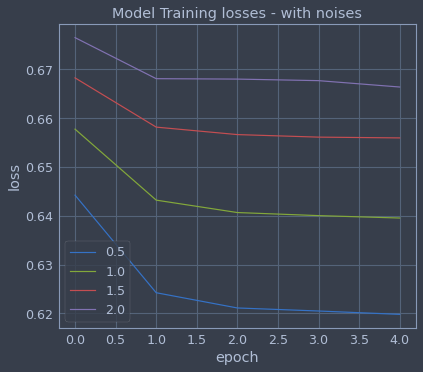

In [54]:
getLossPlots(noise_scales,history)

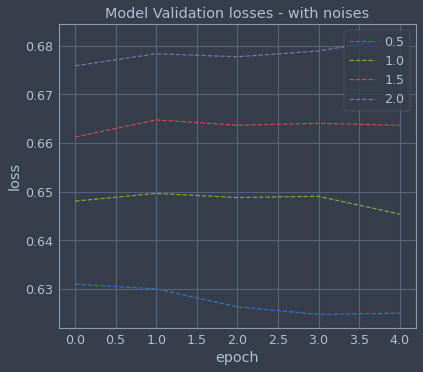

In [55]:
def getValLossPlots(noise_scales,history):
    for scale in noise_scales:
        plt.plot(history[str(scale)].history["val_loss"],"--")
    plt.legend([str(scale) for scale in noise_scales])
    plt.title("Model Validation losses - with noises")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.show()
    
getValLossPlots(noise_scales,history)

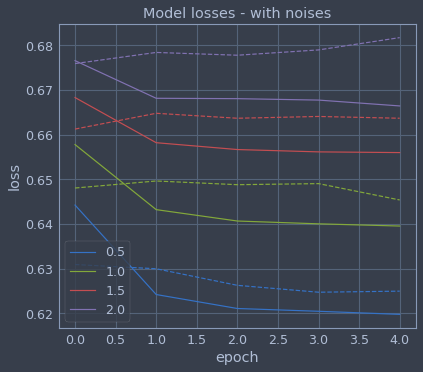

In [56]:
for scale in noise_scales:
    plt.plot(history[str(scale)].history["loss"])
plt.legend([str(scale) for scale in noise_scales])
plt.gca().set_prop_cycle(None)
for scale in noise_scales:
        plt.plot(history[str(scale)].history["val_loss"],"--")
plt.title("Model losses - with noises")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()